In [0]:
!pip3 uninstall pytorch-hrvvi-ext
!pip3 install -U --no-cache-dir --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple pytorch-hrvvi-ext

In [0]:
import sys
import os

import torch
import hutil
import matplotlib.pyplot as plt
print(hutil.__version__)

1.4.5


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
gdrive = "/gdrive"
from google.colab import drive
drive.mount(gdrive, force_remount=True)
mydrive = os.path.join(gdrive, "My Drive")

def gpath(p):
    return os.path.join(mydrive, p)

Mounted at /gdrive


In [0]:
import numpy as np

from toolz import curry

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

from torchvision.datasets import STL10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, Lambda
from torchvision.utils import save_image

from hutil import cuda
from hutil.data import train_test_split
from hutil.train import GANTrainer
from hutil.train.metrics import LossD, LossG


In [0]:

transform = Compose([
    ToTensor(),
    Normalize((0.4467, 0.4398, 0.4066), (0.2603, 0.2565, 0.2712)),
    Lambda(lambda t: torch.tanh(t))
])

data_home = gpath("datasets/STL10")
ds_train = STL10(data_home, split="train",
                   transform=transform, download=True)


Files already downloaded and verified


In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [0]:

class Generator(nn.Module):
    def __init__(self, in_channels, channels, out_channels):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels, channels * 8, 3, 1, 0),
            # 3 * 3
            nn.BatchNorm2d(channels * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(channels * 8, channels * \
                               8, 4, 2, 1),
            # 6 * 6
            nn.BatchNorm2d(channels * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(channels * 8, channels * \
                               4, 4, 2, 1),
            # 12 * 12
            nn.BatchNorm2d(channels * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(channels * 4, channels * \
                               2, 4, 2, 1),
            # 24 * 24
            nn.BatchNorm2d(channels * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(channels * 2, channels * \
                               1, 4, 2, 1),
            # 48 * 48
            nn.BatchNorm2d(channels * 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(channels, out_channels, 4, 2, 1),
            # 96 * 96
            nn.Tanh()
        )

    def forward(self, x):
        x = self.main(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, in_channels, channels):
        super().__init__()
        self.main = nn.Sequential(
            # 96 * 96
            nn.Conv2d(in_channels, channels * 1, 5, 3, 1),
            # 32 * 32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels * 1, channels * 2, 4, 2, 1),
            # 16 * 16
            nn.BatchNorm2d(channels * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels * 2, channels * 4, 4, 2, 1),
            # 8 * 8
            nn.BatchNorm2d(channels * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels * 4, channels * 4, 4, 2, 1),
            # 4 * 4
            nn.BatchNorm2d(channels * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels * 4, 1, 4, 1, 0),
            # 1 * 1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)



In [0]:

def gen_labels(batch_size, real_label, fake_label):
    y_real = torch.full((batch_size,), real_label)
    y_real += torch.rand((batch_size,)) / 2 - 0.3
    y_fake = torch.full((batch_size,), fake_label)
    y_fake += torch.rand((batch_size,)) * 0.3
    return y_real, y_fake


@curry
def gan_collate_fn(batch, in_channels, real_label, fake_label):
    real, _ = zip(*batch)
    real = default_collate(real)
    batch_size_t = real.size(0)
    y = gen_labels(batch_size_t, real_label, fake_label)
    noise = torch.randn(batch_size_t, in_channels, 1, 1)
    return (real, noise), y


@curry
def save_generated(trainer, noise, save_per_epochs=5):
    epoch = trainer.epochs()
    if epoch % save_per_epochs == 0:
        save_image(trainer.G(noise), gpath("images/t_%d.jpg") %
                   epoch, nrow=8, normalize=True)



In [0]:
REAL_LABEL = 1
FAKE_LABEL = 0
in_channels = 128
channels = 64
beta1 = 0.5
batch_size = 32


In [0]:
G = Generator(in_channels, channels, 3)
G.apply(weights_init)
optimizerG = Adam(G.parameters(), lr=1e-3, betas=(beta1, 0.999))
lr_schedulerG = LambdaLR(optimizerG, lambda x: 0.98 ** x)

D = Discriminator(3, channels)
D.apply(weights_init)
optimizerD = Adam(D.parameters(), lr=4e-4, betas=(beta1, 0.999))
lr_schedulerD = LambdaLR(optimizerD, lambda x: 0.98 ** x)


In [0]:

criterion = nn.BCELoss()

metrics = {
    "lossG": LossG(),
    "lossD": LossD(),
}
trainer = GANTrainer(G, D, criterion, optimizerG, optimizerD,
                     lr_schedulerG, lr_schedulerD, metrics=metrics)

In [0]:
fixed_noise = cuda(torch.randn(64, in_channels, 1, 1))

train_loader = DataLoader(ds_train, batch_size=batch_size,
                          num_workers=1, pin_memory=True,
                          collate_fn=gan_collate_fn(
                              in_channels=in_channels,
                              real_label=REAL_LABEL,
                              fake_label=FAKE_LABEL))


In [17]:
trainer.fit(train_loader, epochs=20, callbacks=[
            save_generated(noise=fixed_noise)])


Epoch 46/65
elapsed: 28s	lossG: 1.6572	lossD: 0.8907	
Epoch 47/65
elapsed: 27s	lossG: 1.6743	lossD: 0.8823	
Epoch 48/65
elapsed: 27s	lossG: 1.6760	lossD: 0.8638	
Epoch 49/65
elapsed: 28s	lossG: 1.6987	lossD: 0.8480	
Epoch 50/65
elapsed: 27s	lossG: 1.7245	lossD: 0.8584	
Epoch 51/65
elapsed: 27s	lossG: 1.7002	lossD: 0.8519	
Epoch 52/65
elapsed: 27s	lossG: 1.7213	lossD: 0.8273	
Epoch 53/65
elapsed: 27s	lossG: 1.7510	lossD: 0.8377	
Epoch 54/65
elapsed: 24s	lossG: 1.7461	lossD: 0.8384	
Epoch 55/65
elapsed: 21s	lossG: 1.7312	lossD: 0.8152	
Epoch 56/65
elapsed: 21s	lossG: 1.7432	lossD: 0.8210	
Epoch 57/65
elapsed: 21s	lossG: 1.7364	lossD: 0.8048	
Epoch 58/65
elapsed: 21s	lossG: 1.7383	lossD: 0.8133	
Epoch 59/65
elapsed: 21s	lossG: 1.7595	lossD: 0.8144	
Epoch 60/65
elapsed: 21s	lossG: 1.7462	lossD: 0.8099	
Epoch 61/65
elapsed: 21s	lossG: 1.7573	lossD: 0.7930	
Epoch 62/65
elapsed: 21s	lossG: 1.7591	lossD: 0.7861	
Epoch 63/65
elapsed: 24s	lossG: 1.7758	lossD: 0.8072	
Epoch 64/65
elapsed: 24s	los

{'lossD': [0.8906996307373047,
  0.8822717771530152,
  0.8638275186538696,
  0.8479510272979737,
  0.8583685527801513,
  0.8518960173606872,
  0.8272703936576843,
  0.837679328918457,
  0.8384081182479859,
  0.8152071647644042,
  0.820956071472168,
  0.8047806518554688,
  0.8132827890396118,
  0.8144115531921386,
  0.8098877594947815,
  0.7930274927139283,
  0.7860513814926148,
  0.8071873239517212,
  0.777257925415039,
  0.8137003186225891],
 'lossG': [1.6572136276245117,
  1.6743116539001466,
  1.6760085765838624,
  1.6987269905090332,
  1.7244629211425782,
  1.700221017074585,
  1.721330563735962,
  1.7510039386749268,
  1.7460707025527955,
  1.73118627243042,
  1.7432226018905639,
  1.736441384601593,
  1.7382901948928833,
  1.7595182640075684,
  1.7462021057128907,
  1.7572905963897705,
  1.7591141941070556,
  1.7758045288085937,
  1.7731115760803222,
  1.7572917432785033]}

In [0]:
from PIL import Image

In [0]:
img = Image.open(gpath("images/t_65.jpg"))

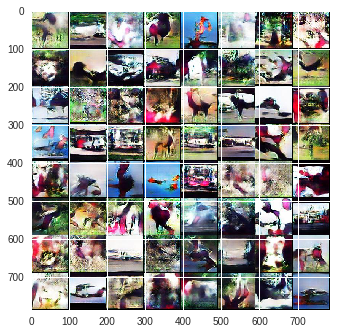

In [22]:
plt.imshow(img)